In [2]:
# Author Bereket Kebede, Graduate Student
# Neural Networks -  Assignment #3 - University of Memphis. Fall 2021
# Question #1, Transfer Learnining, ResNet50 on TinyImage
# Last updated - Oct 10, 2021

In [38]:
#####################################################################################
# Import necessary libraries

import time
import scipy.ndimage as nd
import imageio 
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import Sequential, Input
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout, Activation, MaxPool2D, Flatten
from keras.callbacks import ReduceLROnPlateau, CSVLogger, EarlyStopping
from sklearn.ensemble import VotingClassifier
from keras.wrappers.scikit_learn import KerasClassifier


In [11]:
#####################################################################################
# Load Training and Testing data, TinyImageNet

path = 'C:/Users/CIRL/Desktop/Bereket/Neural Networks/Assignment 3/archive/tiny-imagenet-200/'

def get_id_dictionary():
    id_dict = {}
    for i, line in enumerate(open( path + 'wnids.txt', 'r')):
        id_dict[line.replace('\n', '')] = i
    return id_dict
  
def get_class_to_id_dict():
    id_dict = get_id_dictionary()
    all_classes = {}
    result = {}
    for i, line in enumerate(open( path + 'words.txt', 'r')):
        n_id, word = line.split('\t')[:2]
        all_classes[n_id] = word
    for key, value in id_dict.items():
        result[value] = (key, all_classes[key])      
    return result

def get_data(id_dict):
    print('starting loading data')
    train_data, test_data = [], []
    train_labels, test_labels = [], []
    t = time.time()
    for key, value in id_dict.items():
        train_data += [cv2.imread( path + 'train/{}/images/{}_{}.JPEG'.format(key, key, str(i))) for i in range(500)]
        train_labels_ = np.array([[0]*200]*500)
        train_labels_[:, value] = 1
        train_labels += train_labels_.tolist()

    for line in open( path + 'val/val_annotations.txt'):
        img_name, class_id = line.split('\t')[:2]
        test_data.append(cv2.imread( path + 'val/images/{}'.format(img_name)))
        test_labels_ = np.array([[0]*200])
        test_labels_[0, id_dict[class_id]] = 1
        test_labels += test_labels_.tolist()

    print('finished loading data, in {} seconds'.format(time.time() - t))
    return np.array(train_data), np.array(train_labels), np.array(test_data), np.array(test_labels)
  
train_data, train_labels, test_data, test_labels = get_data(get_id_dictionary())

print( "train data shape: ",  train_data.shape )
print( "train label shape: ", train_labels.shape )
print( "test data shape: ",   test_data.shape )
print( "test_labels.shape: ", test_labels.shape )

starting loading data
finished loading data, in 19.709442853927612 seconds
train data shape:  (100000, 64, 64, 3)
train label shape:  (100000, 200)
test data shape:  (10000, 64, 64, 3)
test_labels.shape:  (10000, 200)


In [12]:
#####################################################################################
# Shuffle data

def shuffle_data(train_data, train_labels ):
    size = len(train_data)
    train_idx = np.arange(size)
    np.random.shuffle(train_idx)

    return train_data[train_idx], train_labels[train_idx]
  
train_data, train_labels = shuffle_data(train_data, train_labels)

In [13]:
#####################################################################################
# pre-processing data

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1), cooldown=0, patience=5, min_lr=0.5e-6)
early_stopper = EarlyStopping(min_delta=0.001, patience=10)
csv_logger = CSVLogger('resnet50_tiny_ImageNet.csv')

batch_size = 500
nb_classes = 200
nb_epoch = 10

# input image dimensions
img_rows, img_cols = 64, 64
# The images are RGB
img_channels = 3
# The data, shuffled and split between train and test sets:
X_train = train_data
Y_train = train_labels
X_test = test_data
Y_test = test_labels

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# subtract mean and normalize
mean_image = np.mean(X_train, axis=0)
X_train -= mean_image
X_test -= mean_image
X_train /= 128.
X_test /= 128.

In [14]:
model = Sequential([
        Input(shape=(64,64,3)),
        tf.keras.applications.resnet50.ResNet50(include_top=False, pooling='avg'),
        Dropout(0.4),
        Dense(200, activation='softmax')
    ])

In [15]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 200)               409800    
Total params: 23,997,512
Trainable params: 23,944,392
Non-trainable params: 53,120
_________________________________________________________________


In [18]:
#####################################################################################
# Data augmentation

datagen = ImageDataGenerator(
          featurewise_center=False,           # set input mean to 0 over the dataset
          samplewise_center=False,            # set each sample mean to 0
          featurewise_std_normalization=False,# divide inputs by std of the dataset
          samplewise_std_normalization=False, # divide each input by its std
          zca_whitening=False,                # apply ZCA whitening
          rotation_range=0,                   # randomly rotate images in the range (degrees, 0 to 180)
          width_shift_range=0.1,              # randomly shift images horizontally (fraction of total width)
          height_shift_range=0.1,             # randomly shift images vertically (fraction of total height)
          horizontal_flip=True,               # randomly flip images
          vertical_flip=False )               # randomly flip images

# Compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied).
datagen.fit( X_train )

print('Data augemntation done')

Data augemntation done


In [63]:
#####################################################################################
# Load Training and Testing data, for fine tuning jump this stage
# ** Don't train for testing use saved models

epoch = 10 # epoch 1-10

# Fit the model on the batches generated by datagen.flow().
history = model.fit(datagen.flow(X_train, Y_train, batch_size=batch_size),
                     steps_per_epoch=X_train.shape[0] // batch_size,
                     validation_data=(X_test, Y_test),
                     epochs=epoch, verbose=1,
                     callbacks=[lr_reducer, early_stopper, csv_logger] )

Epoch 1/10
200/200 [==============================] - 68s 337ms/step - loss: 1.2007 - accuracy: 0.6733 - val_loss: 2.3503 - val_accuracy: 0.4786
Epoch 2/10
200/200 [==============================] - 65s 325ms/step - loss: 1.1155 - accuracy: 0.6910 - val_loss: 2.2100 - val_accuracy: 0.5019
Epoch 3/10
200/200 [==============================] - 65s 325ms/step - loss: 1.0315 - accuracy: 0.7119 - val_loss: 2.3023 - val_accuracy: 0.4890
Epoch 4/10
200/200 [==============================] - 66s 329ms/step - loss: 0.9643 - accuracy: 0.7307 - val_loss: 2.1906 - val_accuracy: 0.5073
Epoch 5/10
200/200 [==============================] - 66s 327ms/step - loss: 0.8981 - accuracy: 0.7449 - val_loss: 2.3173 - val_accuracy: 0.4954
Epoch 6/10
200/200 [==============================] - 65s 326ms/step - loss: 0.8275 - accuracy: 0.7646 - val_loss: 2.3260 - val_accuracy: 0.5001
Epoch 7/10
200/200 [==============================] - 66s 328ms/step - loss: 0.7529 - accuracy: 0.7820 - val_loss: 2.4980 - val_ac

In [64]:
scores = model.evaluate(X_test, Y_test, verbose=1)
print('\nAccuracy:', scores[1])

model.save('model_resnet50.h5')
model.save_weights('pre_trained_weights_resnet50.h5')

313/313 [==============================] - 4s 14ms/step - loss: 2.1671 - accuracy: 0.5651

Accuracy: 0.5651000142097473


Plotting training loss



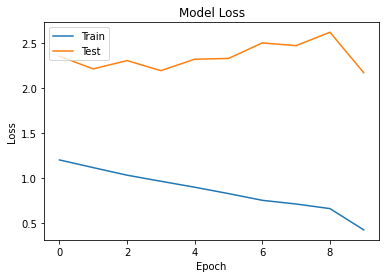

In [66]:
#####################################################################################
# Plotting training loss

print('Plotting training loss\n')
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

Plotting training accuracy



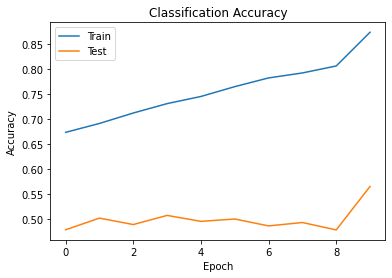

In [67]:
#####################################################################################
# Plotting training accuracy

print('Plotting training accuracy\n')
plt.plot(history.history['accuracy'])
plt.title('Classification Accuracy')
plt.ylabel('Accuracy')
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [26]:
#####################################################################################
# Fine-tuning model with previous model pre-trained weights, Q#2
# ** Don't train for testing use saved models

model.load_weights('model_resnet50.h5')

epoch = 10 # epoch 1-10

# Fit the model on the batches generated by datagen.flow().
history = model.fit(datagen.flow(X_train, Y_train, batch_size=batch_size),
                     steps_per_epoch=X_train.shape[0] // batch_size,
                     validation_data=(X_test, Y_test),
                     epochs=epoch, verbose=1,
                     callbacks=[lr_reducer, early_stopper, csv_logger] )

Epoch 1/10
200/200 [==============================] - 74s 330ms/step - loss: 0.6210 - accuracy: 0.8151 - val_loss: 2.5355 - val_accuracy: 0.4995
Epoch 2/10
200/200 [==============================] - 65s 326ms/step - loss: 0.5864 - accuracy: 0.8245 - val_loss: 2.4640 - val_accuracy: 0.5053
Epoch 3/10
200/200 [==============================] - 65s 324ms/step - loss: 0.5372 - accuracy: 0.8375 - val_loss: 2.6425 - val_accuracy: 0.4925
Epoch 4/10
200/200 [==============================] - 66s 327ms/step - loss: 0.5123 - accuracy: 0.8453 - val_loss: 2.6095 - val_accuracy: 0.4929
Epoch 5/10
200/200 [==============================] - 65s 325ms/step - loss: 0.4819 - accuracy: 0.8538 - val_loss: 2.7167 - val_accuracy: 0.4941
Epoch 6/10
200/200 [==============================] - 66s 327ms/step - loss: 0.4463 - accuracy: 0.8637 - val_loss: 2.6383 - val_accuracy: 0.5067
Epoch 7/10
200/200 [==============================] - 66s 327ms/step - loss: 0.4295 - accuracy: 0.8689 - val_loss: 2.7315 - val_ac

In [27]:
scores = model.evaluate(X_test, Y_test, verbose=1)
print('\nAccuracy:', scores[1])

model.save('model_resnet50_fine_tuned.h5')

313/313 [==============================] - 4s 14ms/step - loss: 2.5095 - accuracy: 0.5560

Accuracy: 0.5559999942779541


C:\Users\CIRL\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Plotting training loss



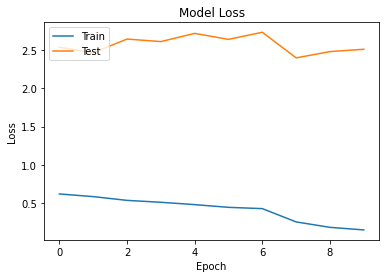

Plotting training accuracy



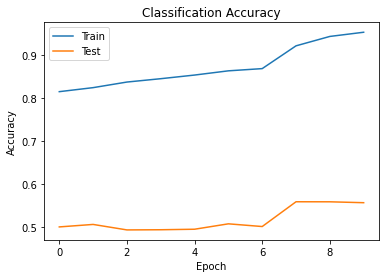

In [31]:
#####################################################################################
# Plotting training loss

print('Plotting training loss\n')
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

#####################################################################################
# Plotting training accuracy

print('Plotting training accuracy\n')
plt.plot(history.history['accuracy'])
plt.title('Classification Accuracy')
plt.ylabel('Accuracy')
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()